# Mercarri Price Suggestion

In this project I am dealing with the data provided by [Mercarri](https://www.mercari.com/) e-commerce company, which is mainly operated in japan. The problem here is I have to predict the prices of the products which have been provided by Mercarri.

This project follows **CRISP-DM** architectecture and also satisfies **PEP-8** Convention.

## Business Understanding

Generally, Right choice of pricing a product can never be static, it has to be varying based on the market demand for that,I build a model that automatically suggests the right product prices. There are various factors which can effect the price of product. Let's dive in detail this in data understanding section.

You can find the data used in this project in [Data](https://www.kaggle.com/saitosean/mercari)

### Importing Dependencies
First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of code

In [90]:
# Importing dependecies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from wordcloud import WordCloud

## Data Understanding

Let us understand the each attribute present in the data more carefully. We have total of 8 attributes and 6 million records in train data.


* train_id  — the id of the listing


* name   —  the title of the listing


* item_condition_id   —  the condition of the items provided by the sellers


* category_name  —  category of the listing


* brand_name  —  the name of the brand


* price  —  the price that the item was sold for. This is target variable that we will predict


* shipping  —  1 if shipping fee is paid by seller and 0 by buyer


* item_description  —  the full description of the item

## Data preparation.

Let us further split the train data set in training and validation dataset. We will split the data into 80 percent training data and 20 percent testing data. Do some exploration on training data set.

### Get the data

In [47]:
def train_val_split(train_data_path):
    """
    Split the training data into train and validation data
    :dataframe: 
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    train_dataframe = pd.read_csv(train_data_path, sep = '\t')
    index = np.random.rand(len(train_dataframe)) < 0.8
    train_data = train_dataframe[index]
    val_data = train_dataframe[~index]
    return train_data,val_data

### Explorative Data Analysis

In [48]:
# Get the training data after split
train_df,val_df=train_val_split('train.tsv')
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...


In [49]:
# Get the information about each attribute
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474406 entries, 0 to 593374
Data columns (total 8 columns):
train_id             474406 non-null int64
name                 474406 non-null object
item_condition_id    474406 non-null int64
category_name        472394 non-null object
brand_name           272047 non-null object
price                474406 non-null float64
shipping             474406 non-null int64
item_description     474406 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 32.6+ MB


<b>Let us Explore more on Price attribute</b>

In [50]:
train_df.price.describe()

count    474406.000000
mean         26.667981
std          38.047896
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        2000.000000
Name: price, dtype: float64

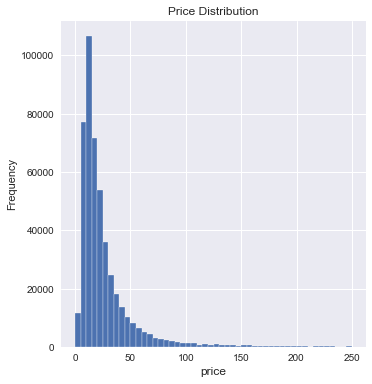

In [55]:
# Distribution of data in price attribute
plt.subplot(1, 2, 1)
(train_df['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.show()

The price of items are left skewed, vast majority of items priced at 10-20. However, the most expensive item priced at 2009. So we make log-transformation on the price.

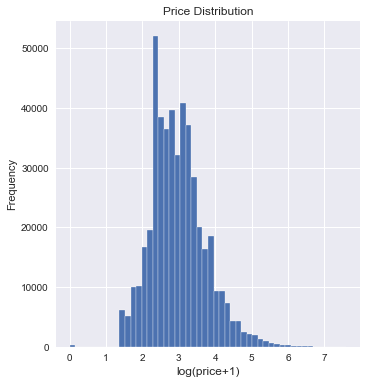

In [53]:
# Distribution of data in price attribute after log normalization
plt.subplot(1, 2, 2)
np.log(train_df['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.show()

<b>Let us Explore more on shipping attribute</b>

In [9]:
# No of items which got shipped
train_df['shipping'].value_counts() / len(train)

0    0.553659
1    0.446341
Name: shipping, dtype: float64

Over 55% of items shipping fee were paid by the buyers. How shipping related to price?

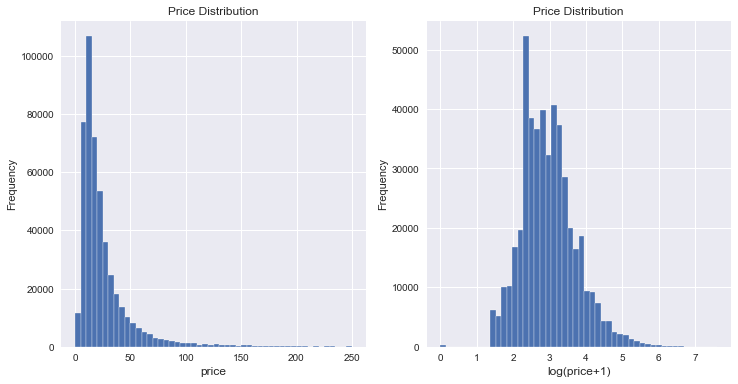

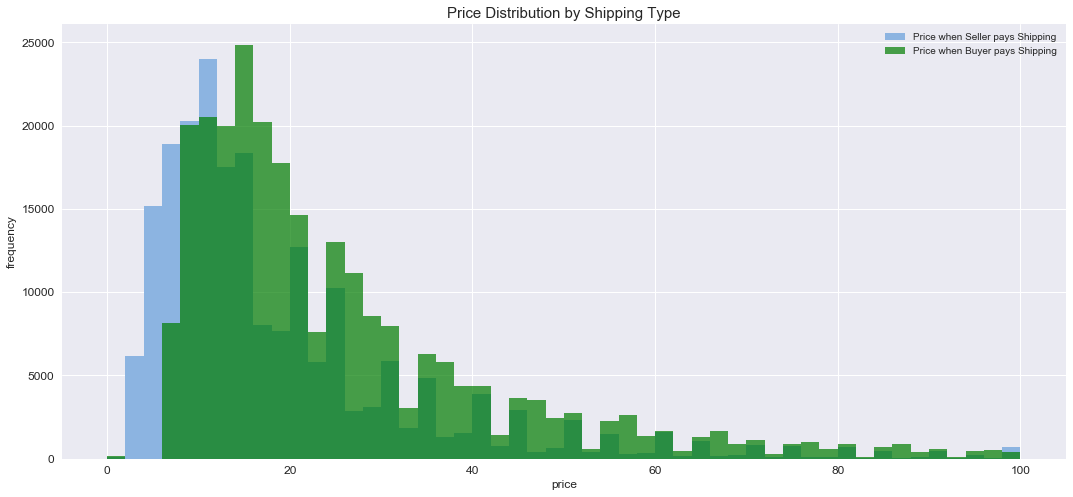

In [10]:
# Price distibution over shipping type
shipping_fee_by_buyer = train_df.loc[df['shipping'] == 0, 'price']
shipping_fee_by_seller = train_df.loc[df['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [11]:
# The average price respective to shipping
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.47 if seller pays shipping
The average price is 30.01 if buyer pays shipping


We compare again after log-transformation on the price.

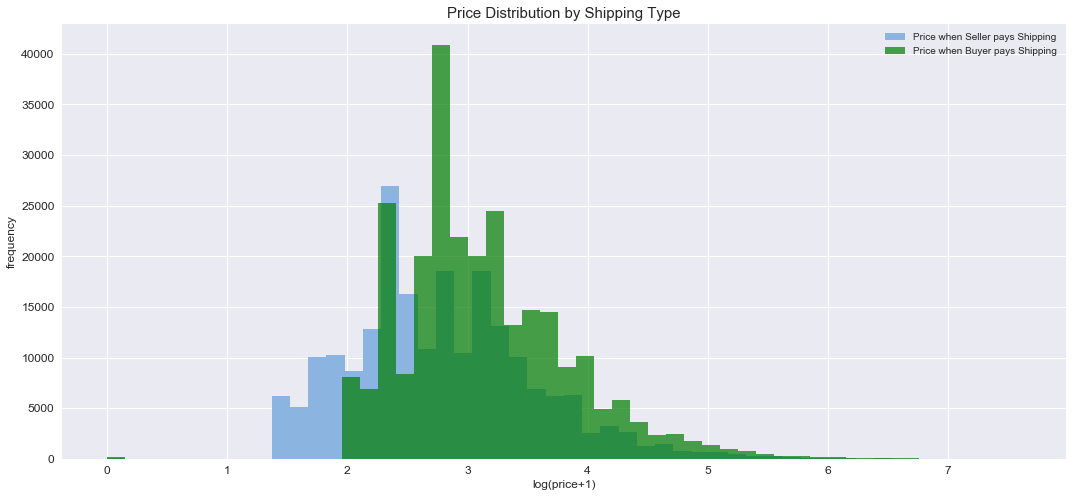

In [12]:
# Price dustribution by shipping type
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

It is obvious that the average price is higher when buyer pays shipping.

### Let us explore more on category_name attribute

In [13]:
print('There are', train_df['category_name'].nunique(), 'unique values in category name column')

There are 1172 unique values in category name column


Top 10 most common category names

In [14]:
train_df['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 19095
Women/Tops & Blouses/T-Shirts                                  14835
Beauty/Makeup/Face                                             11002
Beauty/Makeup/Lips                                              9461
Electronics/Video Games & Consoles/Games                        8593
Beauty/Makeup/Eyes                                              8112
Electronics/Cell Phones & Accessories/Cases, Covers & Skins     7894
Women/Underwear/Bras                                            6904
Women/Tops & Blouses/Tank, Cami                                 6567
Women/Tops & Blouses/Blouse                                     6558
Name: category_name, dtype: int64

### Item condition vs. Price

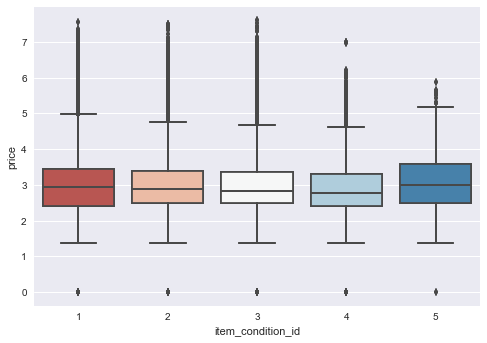

In [58]:
sns.boxplot(x = 'item_condition_id', y = np.log(train_df['price']+1), data = train_df, palette = sns.color_palette('RdBu',5))
plt.show()

There seems to be various on the average price between each item condition id.

**Therefore, we are going to use all the features to build our model.**

## Modelling

For modelling this problem, I have choosen GBM because I need a model where feature importance can be explained better and I explain the percentage of variance explained by most dominating factor and more efficient in capturing non linearity in data, so have choosen tree based model.

### Constants across attributes

In [16]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

### Handling missing and categorical columns

This section is about handling missing values and categorical columns. We are filling missing values with external keyword as **missing** reason for this is it might be useful in feature selection process let us check it

There are missing values in the columns.

In [17]:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 2040 items that do not have a category name.


In [18]:
print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())

There are 202703 items that do not have a brand name.


In [19]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())

There are 1 items that do not have a description.


In [20]:
def handle_missing_inplace(dataset): 
    """
    Handles the missing values by adding a word missing
    :dataset: 
    :we are merging the optput using merge function later instead of returning from here
    """
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)

In [21]:
def cutting(dataset):
    """
    Slices the dataset by using model parameters
    :dataframe: 
    :we are merging the optput using merge function later instead of returning from here
    """
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

In [61]:
def to_categorical(dataset):
    """
    Converting the following attributes to category so that we can derive dummies
    from this later in this project
    :dataframe: 
    :we are merging the optput using merge function later instead of returning from here
    """
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [23]:
# Get the data from split data function
val_df_new = val_df.drop('price', axis=1)
y_val = np.log1p(test["price"])

Drop rows where price = 0

In [24]:
def merge_dataframe():
    """
    After modifying val dataset and slicing using model constants we are merging the dataframe
    :dataframe 
    :merged dataframe
    """
    train_df = train_df[train_df.price != 0].reset_index(drop=True)
    nrow_train = train_df.shape[0]
    y = np.log1p(train_df["price"])
    merge: pd.DataFrame = pd.concat([train_df, val_df_new])
    handle_missing_inplace(merge)
    cutting(merge)
    to_categorical(merge)
    return merge

## Feature Selection

Here we do feature selection by vectorizing the item description using tf-idf so that we can get the important features of unnderlying text and downsample the most frequented words.

Count vectorize name and category name columns.

In [28]:
merge=merge_dataframe()
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

In [29]:
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

TFIDF Vectorize item_description column.

In [30]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

Label binarize brand_name column.

In [31]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

Create dummy variables for item_condition_id and shipping columns.

In [32]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

Create sparse merge.

In [33]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [34]:
sparse_merge.shape

(593126, 66110)

Remove features with document frequency <=1.

In [35]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [36]:
sparse_merge.shape

(593126, 64915)

Separate train and test data from sparse merge.

In [37]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]

In [38]:
train_X = lgb.Dataset(X, label=y)

### Hyper parameters

Learning rate, max_depth and num_leaves we set as 100 because we want to avoid overfitting

In [39]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

### Training
Training a model requires a parameter list and data set. And training will take a while.

In [40]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

## Evaluation

In [41]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [42]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.4797012687042281


## Bussiness Question 1

### Which feature is most important for price of the product? Show some insight.

Yes we can get the feature which is explaining most variance in the price by doing feature importance. Let us try it

In [74]:
gain = gbm.feature_importance('gain')
feature_dataframe = pd.DataFrame({'feature':gbm.feature_name(), 'split':gbm.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)

In [79]:
feature_dataframe[['gain','split']].head()

,gain,split
0,8.517256,314
52610,5.073733,235
59701,4.463775,30
6161,2.779344,62
53329,2.559306,34


### Item Condition

Condition of item is playing a crucial role in and it is capturing 8 percent of variance of the dependent variable that also indicates that it is root node of GBM with split range around 314.

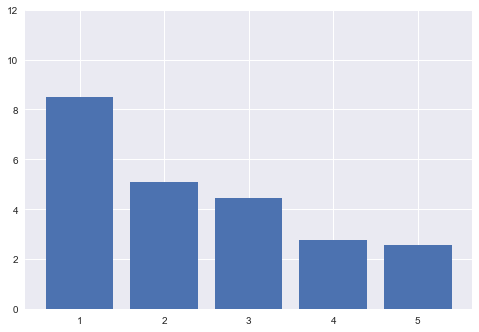

In [88]:
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
plt.bar(x,y) 
plt.show()

## Bussiness Question 2

### Is Item description is needed, If needed what are the most dominating words which appealed customers to purchase?

Yes Item description is very much needed you can see that as second dominating feature with 6 percentage of information gain what are the words which dominating the most, let us see.

In [134]:
# Creating tf-idf vectorizer and Apply 50 percent weightage for most weightage words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer(tokenizer=re_tok.sub(r' ', s).split(),max_df=0.5,ngram_range=(1, 3))
tf_vec=vec.fit_transform(merge['item_description'])

In [135]:
indices = np.argsort(vec.idf_)[::-1]
features = vec.get_feature_names()
top_n = len(features)
top_features = [features[i] for i in indices[1:40]]

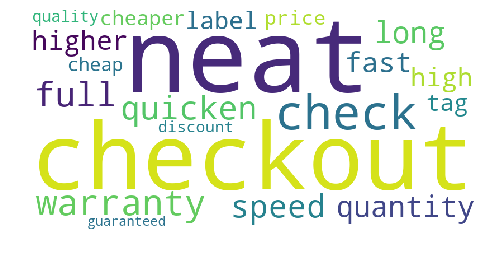

In [166]:
clean_mask=np.array(Image.open("images.png"))
dict_word={}
for k,v in zip(top_features,weights):
    dict_word[k] = v
wordcloud = WordCloud(mask=clean_mask,background_color='white',width=800,height=400, max_words=20,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(dict_word)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("foo.png", dpi=1000)
plt.show()

## Bussiness question 3

### What are the brand qualities which are well conditioned out of all items, So that we can maximize ROI, Can you get it for me?

Yes, we can get the brand which attribute most to quality by doing some correspondence analysis. Let us start it

In [230]:
# Condition Id 1 -- poor 2--average 3 -- well conditioned 
grouped_df=train_df.groupby('brand_name',as_index=False)
agg_df=grouped_df.aggregate('mean')
# Get the brands which are well conditioned
well_conditioned=agg_df.loc[agg_df['item_condition_id']==3.0]['brand_name'].dropna()
# Get the brands which are average conditioned
average_conditioned=agg_df.loc[(agg_df['item_condition_id']>2.0)&(agg_df['item_condition_id']<3.0)]['brand_name'].dropna()
# Get the brands which are not conditioned
not_conditioned=agg_df.loc[(agg_df['item_condition_id']<2.0)&(agg_df['item_condition_id']>1.0)]['brand_name'].dropna()

In [217]:
agg_df.head()

,brand_name,train_id,item_condition_id,price,shipping
0,% Pure,305304.95,1.3,13.85,0.7
1,10.Deep,387759.00,3.0,21.00,0.0
2,21men,286831.00,3.0,10.00,1.0
3,2K Games,266199.00,1.0,9.00,0.0
4,2XU,521269.50,2.0,32.00,0.5


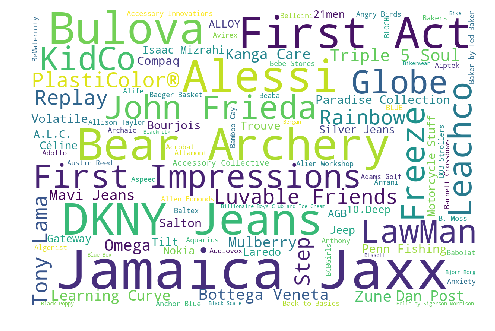

In [224]:
# Conditioned
brand_dict={}
for brand,cond_id in agg_df[['brand_name','item_condition_id']].values:
    brand_dict[brand]=cond_id
wordcloud = WordCloud(background_color='white',width=1200,height=800, max_words=100,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(brand_dict)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("brand.png", dpi=1000)
plt.show()

In [235]:
# the distibution percentage of well_conditioned
full_conditioned_ratio=len(well_conditioned)*100/len(agg_df)

In [236]:
# the distibution percentage of average
average_conditioned_ratio=len(average_conditioned)*100/len(agg_df)

In [238]:
# the distibution percentage of not well
not_conditioned_ratio=len(not_conditioned)*100/len(agg_df)
nan_ratio=100-(not_conditioned_ratio+average_conditioned_ratio+full_conditioned_ratio)

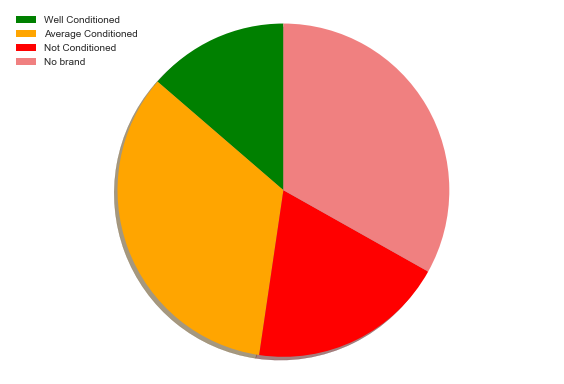

In [239]:
import matplotlib.pyplot as plt
 
labels = ['Well Conditioned', 'Average Conditioned', 'Not Conditioned', 'No brand']
sizes = [full_conditioned_ratio, average_conditioned_ratio, not_conditioned_ratio, nan_ratio]
colors = ['green', 'orange', 'red', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

## References

* https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
* https://pythonspot.com
* https://pandas.pydata.org/

